In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
import pickle
from sklearn import preprocessing
from sklearn import svm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy
from scipy.stats import spearmanr
from collections import defaultdict

In [3]:
X_train, y_train, X_test, y_test = pickle.load(open('Data/adult_income/processed_data.pkl', 'rb'))



In [22]:
all_predictions = []
for rs in range(30):
    np.random.seed(rs)
    
    # bootstrapping
    samples = np.random.choice(np.arange(len(X_train)), len(X_train))
    X_train_this, y_train_this = X_train.iloc[samples], y_train.iloc[samples]
    
#     model = svm.SVC(class_weight='balanced', random_state=rs)
    model = RandomForestClassifier(n_estimators=1, class_weight='balanced', random_state=rs)
    model.fit(X_train_this, y_train_this)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test,predictions)
    prec = precision_score(y_test,predictions)
    roc_auc = roc_auc_score(y_test,predictions)
    all_predictions.append(predictions)
#     print("Accuracy: {0}, Precision: {1}, ROC AUC: {2}".format(accuracy, prec, roc_auc))

Accuracy: 0.8092297476759628, Precision: 0.6155350656607991, ROC AUC: 0.7371393224210124
Accuracy: 0.801195219123506, Precision: 0.5971916299559471, ROC AUC: 0.7287155024743054
Accuracy: 0.8041168658698539, Precision: 0.6041666666666666, ROC AUC: 0.7311988484963836
Accuracy: 0.7936918990703852, Precision: 0.5795119334942344, ROC AUC: 0.7230129425199848
Accuracy: 0.7960159362549801, Precision: 0.5858392564242756, ROC AUC: 0.7229132565664256
Accuracy: 0.795484727755644, Precision: 0.5840108401084011, ROC AUC: 0.7236545964979063
Accuracy: 0.798406374501992, Precision: 0.588016967126193, ROC AUC: 0.731331842405786
Accuracy: 0.80332005312085, Precision: 0.5990870032223415, ROC AUC: 0.7357734583174724
Accuracy: 0.7963479415670651, Precision: 0.5836195508586526, ROC AUC: 0.7291473163304149
Accuracy: 0.798871181938911, Precision: 0.5887331393811162, ROC AUC: 0.73236890940236
Accuracy: 0.7962151394422311, Precision: 0.5831357048748353, ROC AUC: 0.7294237723639132
Accuracy: 0.8037184594953519, P

## Investigating what is a shared trait amongst those most likely to be wrong

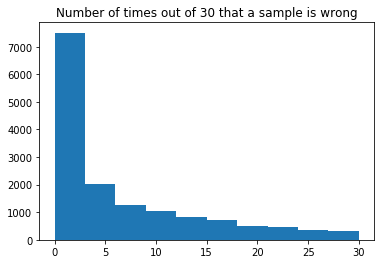

In [23]:
num_wrongs = np.zeros(len(y_test))
for predictions in all_predictions:
    wrongs = np.array(y_test!=predictions)
    num_wrongs += wrongs

plt.hist(num_wrongs)
plt.title('Number of times out of {} that a sample is wrong'.format(len(all_predictions)))
plt.show()



R^2 score: 0.33527102243368695


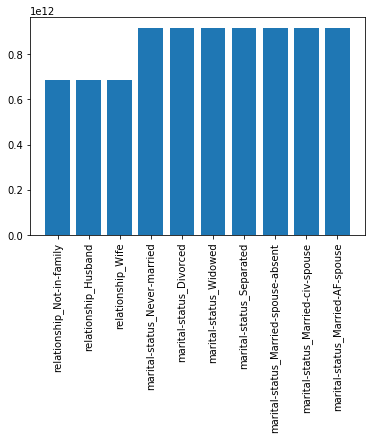

In [24]:
model = LinearRegression()
model.fit(X_test, num_wrongs)
importance = model.coef_
print("R^2 score: {}".format(model.score(X_test, num_wrongs)))
# plt.bar(X_train.keys(), importance)
# plt.show()

most_important = np.argsort(np.absolute(importance))[-10:]
plt.bar(np.array(X_train.keys())[most_important], np.array(importance)[most_important])
plt.xticks(rotation='vertical')
plt.show()

In [10]:
model = svm.SVR()

model.fit(X_test, num_wrongs)
print("R^2 score: {}".format(model.score(X_test, num_wrongs)))

importance = permutation_importance(model, X_test, num_wrongs).importances_mean

most_important = np.argsort(np.absolute(importance))[-10:]
plt.bar(np.array(X_train.keys())[most_important], np.array(importance)[most_important])
plt.xticks(rotation='vertical')
plt.show()

R^2 score: -0.16742531834131147


KeyboardInterrupt: 

## Getting rid of collinear features

In [17]:
corr = spearmanr(X_train).correlation
corr_linkage = hierarchy.ward(corr)
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train.iloc[:, selected_features]
X_test_sel = X_test.iloc[:, selected_features]

clf_sel = RandomForestClassifier()
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 0.85


In [27]:
for key in X_train.keys():
    print(key)

age
fnlwgt
education-num
capital-gain
capital-loss
hours-per-week
workclass_Federal-gov
workclass_Local-gov
workclass_Private
workclass_Self-emp-inc
workclass_Self-emp-not-inc
workclass_State-gov
workclass_Without-pay
education_10th
education_11th
education_12th
education_1st-4th
education_5th-6th
education_7th-8th
education_9th
education_Assoc-acdm
education_Assoc-voc
education_Bachelors
education_Doctorate
education_HS-grad
education_Masters
education_Preschool
education_Prof-school
education_Some-college
marital-status_Divorced
marital-status_Married-AF-spouse
marital-status_Married-civ-spouse
marital-status_Married-spouse-absent
marital-status_Never-married
marital-status_Separated
marital-status_Widowed
occupation_Adm-clerical
occupation_Armed-Forces
occupation_Craft-repair
occupation_Exec-managerial
occupation_Farming-fishing
occupation_Handlers-cleaners
occupation_Machine-op-inspct
occupation_Other-service
occupation_Priv-house-serv
occupation_Prof-specialty
occupation_Protectiv